# What is P300 ??

## 🧠 الـ P300 هو إيه؟





* هو **موجة كهربائية (إشارة مميزة)** بتظهر في الـ EEG.
* بتظهر تقريبًا بعد **300 ملي ثانية (0.3 ثانية)** من لحظة ظهور Stimulus مهم للشخص.
* عشان كده اسمها:

  * **P** = موجة إيجابية (Positive deflection).
  * **300** = حوالي 300 ms بعد الـ stimulus.

---

### 📌 مثال بسيط:

تخيل قدامك شاشة فيها حروف (زي لوحة مفاتيح).

* كل شوية صف أو عمود من الحروف يضوي (وميض).
* إنت مركز على حرف "A".
* لما يضوي العمود أو الصف اللي فيه "A" → يحصل تركيز عقلي → يظهر في المخ **إشارة P300** بعد ~300ms.
* لما يضوي عمود/صف مالوش علاقة بـ "A" → مفيش P300 واضحة.

---

### ✨ خصائص P300:

1. **الزمن (Latency):** بتبدأ بعد 250–300ms وتوصل ذروتها حوالي 400–600ms.
2. **المكان (Scalp location):** أوضح ما يكون في القنوات المركزية والجداريّة (Cz, Pz).
3. **الشكل:** موجة إيجابية (طلعة فوق baseline) مقارنةً بالإشارات العادية.
4. **المعنى:** المخ بيقول "أيوه! لقيت الحاجة اللي كنت بدوّر عليها".

---

### 🎯 الاستخدامات

* **BCI Spellers**: يكتب الشخص بالحروف من خلال التركيز.
* **Emergency Stop**: لو مركز على كلمة "STOP" → النظام يلتقط P300 → يوقف الكرسي أو الروبوت.
* **اختبارات الانتباه والذاكرة**: لأنها مرتبطة بالـ *cognitive processing*.

---

### 🔑 الخلاصة

الـ **P300** = بصمة دماغية بتظهر بعد ما تشوف Stimulus مهم.
هي موجة إيجابية في الـ EEG حوالين 300ms، نقدر نستخدمها كـ **إشارة تحكم** (زي YES/NO أو اختيار حرف).

## What Data contain ?

### وصف البيانات (Context)

- هذه البيانات من التجربة **P300 Speller** من مشروع BNCI Horizon 2020. :contentReference[oaicite:8]{index=8}  
- في هذه التجربة، يُعرض للمستخدم شبكة (مثلاً 6×6) من الحروف، ويتم تفعيل (flash) صفوف أو أعمدة بالتتابع.  
- إذا الفلاش يحتوي الحرف الذي يركز عليه المستخدم، تستجيب دماغه بموجة P300 (~300ms بعد الفلاش).  
- الهدف: باكتشاف استجابة P300، نعرف أي صف وعمود تَفعّلا، ومن ثم الحرف المختار.

### تركيب المصفوفة

الدالة `train` (و `test`) عبارة عن مصفوفة عدد صفوفها 11، وعدد أعمدة = عدد العينات الزمنية:

- الصف 0 → **متجه الزمن**: كل قيمة تمثل الزمن بالثواني لكل عينة.  
- الصفوف 1 إلى 8 → **إشارات EEG** من 8 قنوات تم وضعها على مواقع معيارية مثل Fz, Cz, Pz, Oz, P3, P4, PO7, PO8. :contentReference[oaicite:9]{index=9}  
- الصف 9 → **مؤشّر المحفز (stimulus marker)**: يحدد متى تم تفعيل صف/عمود (فلاش).  
- الصف 10 → **مؤشّر الهدف (target / label channel)**: يحدد أي الفلاشات هي التي تحتوي الحرف المستهدف.

### معلمات التجربة (من الأوراق البحثية)

- معدل أخذ العينات = 256 Hz :contentReference[oaicite:10]{index=10}  
- التصفية المسجلة بين 0.1 و 30 Hz (band-pass) :contentReference[oaicite:11]{index=11}  
- كل اختيار حرف (trial) يتم فيه تفعيل الصفوف والأعمدة عدة مرات، يُقسَّم الفلاشات بين فلاشات تحتوي الهدف وفلاشات لا تحتويه. :contentReference[oaicite:12]{index=12}  
- الهدف هو تمييز الفلاشات التي أثارت استجابة P300 (target) عن الفلاشات العادية (non-target).



# Code

In [1]:
!pip install -q scipy h5py

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import scipy.io
import h5py


### Load Data

In [2]:
mat_path = '/content/drive/MyDrive/ML_Datasets/P300_2015/s1.mat'
print("mat_path:", mat_path)

mat_path: /content/drive/MyDrive/ML_Datasets/P300_2015/s1.mat


In [3]:
def load_mat(path):
    # Try scipy first
    try:
        m = scipy.io.loadmat(path, struct_as_record=False, squeeze_me=True)
        # remove __header__ keys
        m = {k: v for k, v in m.items() if not k.startswith('__')}
        print("Loaded with scipy.io.loadmat; keys:", list(m.keys()))
        return m
    except Exception as e:
        print("scipy.loadmat failed:", e, "\nTrying h5py for v7.3 HDF5 MAT-file...")
        try:
            f = h5py.File(path, 'r')
            def to_py(obj):
                if isinstance(obj, h5py.Dataset):
                    return obj[()]
                if isinstance(obj, h5py.Group):
                    d = {}
                    for k in obj.keys():
                        d[k] = to_py(obj[k])
                    return d
                return None
            out = {}
            for k in f.keys():
                out[k] = to_py(f[k])
            f.close()
            print("Loaded with h5py; keys:", list(out.keys()))
            return out
        except Exception as e2:
            raise RuntimeError("Failed to load .mat with scipy and h5py: %s / %s" % (e, e2))


In [4]:
mat = load_mat(mat_path)

Loaded with scipy.io.loadmat; keys: ['s1']


### Found top-level key

In [5]:
# قد يكون mat['s1'] ملفًّا في صيغة مختلفة. هذه الخلية تحاول الوصول للـ mat_struct أو dict داخل المصفوفة.
if 's1' in mat:
    s1_obj = mat['s1']
    print("Found top-level key 's1' with type:", type(s1_obj))
else:
    # اطبع المفاتيح للمراجعة
    print("Top-level keys:", list(mat.keys()))
    # حاول تعيين الأول
    first_key = list(mat.keys())[0]
    s1_obj = mat[first_key]
    print("Using first key:", first_key, " type:", type(s1_obj))

# عرض تمهيدي
try:
    # if it's scipy mat_struct it might be inside array: s1_obj = s1_obj[0,0]
    print("repr(sample) first 500 chars:\n", repr(s1_obj)[:500])
except Exception:
    pass

# إذا s1_obj هو dict بصيغة {'s1': mat_struct} حيث سبق عندك هذه الحالة:
if isinstance(s1_obj, dict) and 's1' in s1_obj and hasattr(s1_obj['s1'], '_fieldnames'):
    s1_mat = s1_obj['s1']
else:
    # أحيانًا scipy يعطي mat_struct مباشرة
    s1_mat = s1_obj

print("s1_mat type:", type(s1_mat))
if hasattr(s1_mat, '_fieldnames'):
    print("s1_mat fields:", list(s1_mat._fieldnames))


Found top-level key 's1' with type: <class 'scipy.io.matlab._mio5_params.mat_struct'>
repr(sample) first 500 chars:
s1_mat type: <class 'scipy.io.matlab._mio5_params.mat_struct'>
s1_mat fields: ['train', 'test']


### Get train & test

In [6]:
# الوصول إلى المصفوفات train/test (قد تكون مُخزّنة كـ numpy array أو ككائن mat_struct)
def get_attr(obj, name):
    if isinstance(obj, dict):
        return obj.get(name)
    if hasattr(obj, name):
        return getattr(obj, name)
    return None

train = get_attr(s1_mat, 'train')
test  = get_attr(s1_mat, 'test')

print("types:", type(train), type(test))
print("train.shape:", getattr(train, 'shape', None))
print("test.shape:", getattr(test, 'shape', None))

# عرض جزء صغير كنماذج
print("train first row sample (first 10):", train[0, :10])


types: <class 'numpy.ndarray'> <class 'numpy.ndarray'>
train.shape: (11, 65282)
test.shape: (11, 68038)
train first row sample (first 10): [0.         0.00390625 0.0078125  0.01171875 0.015625   0.01953125
 0.0234375  0.02734375 0.03125    0.03515625]


In [7]:
def is_time_vector(row, tol=1e-9):
    diffs = np.diff(row.astype(float))
    if not np.all(np.isfinite(diffs)):
        return False
    if not np.all(diffs >= -tol):
        return False
    mean = np.mean(diffs)
    std = np.std(diffs)
    if mean == 0:
        return False
    cv = std / abs(mean)
    return cv < 0.01  # coef-var < 1%

# prepare
t_train = train[0, :].astype(float)
sig_train = train[1:, :].astype(float)  # shape (10, N)
t_test  = test[0, :].astype(float)
sig_test = test[1:, :].astype(float)

print("sig_train shape:", sig_train.shape)
print("sig_test shape:", sig_test.shape)
print("is t_train time vector?", is_time_vector(t_train))

# sampling rate
dt = np.median(np.diff(t_train))
sr = 1.0 / dt
print(f"median dt = {dt:.6f} s  => sampling rate ≈ {sr:.3f} Hz")


sig_train shape: (10, 65282)
sig_test shape: (10, 68038)
is t_train time vector? True
median dt = 0.003906 s  => sampling rate ≈ 256.000 Hz


Channel names: ['ch0', 'ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8', 'ch9']


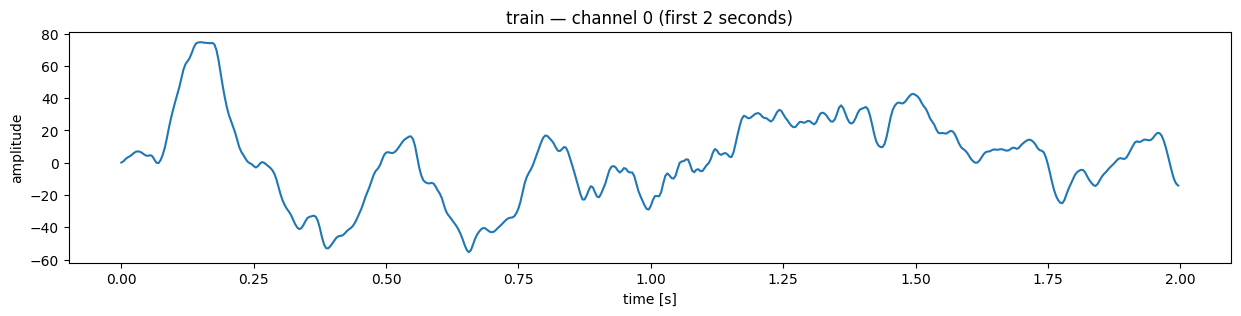

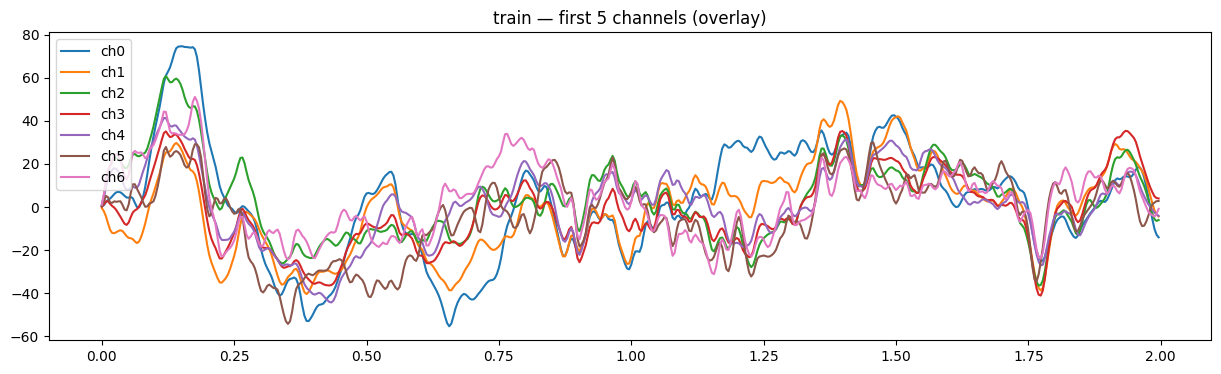

In [8]:

ch_names = [f"ch{i}" for i in range(sig_train.shape[0])]
print("Channel names:", ch_names)

# Plot channel 0 (أول 2 ثانية)
nplot = int(2 * sr)
plt.figure(figsize=(15,3))
plt.plot(t_train[:nplot], sig_train[0, :nplot])
plt.title("train — channel 0 (first 2 seconds)")
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show()

# Overlay first 7 channels (short window)
plt.figure(figsize=(15,4))
for i in range(min(7, sig_train.shape[0])):
    plt.plot(t_train[:nplot], sig_train[i, :nplot] + i*0, label=ch_names[i])
plt.legend()
plt.title("train — first 5 channels (overlay)")
plt.show()


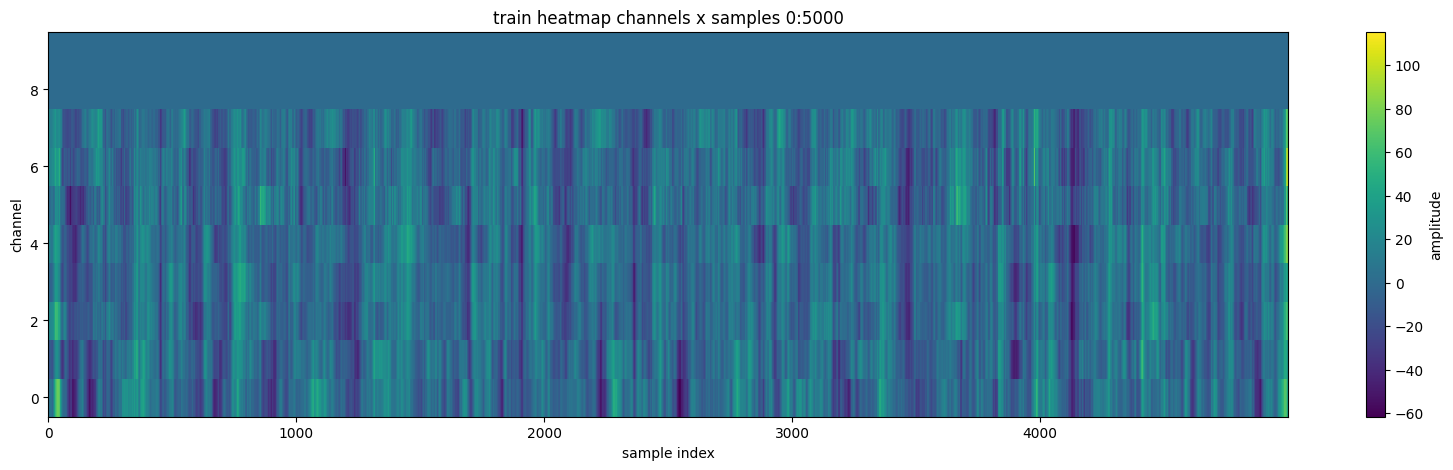

In [9]:
start = 0
window = 5000  # samples (مثلاً ما يعادل ~19.5 ثانية عند 256Hz)
end = min(sig_train.shape[1], start + window)
plt.figure(figsize=(20,5))
plt.imshow(sig_train[:, start:end], aspect='auto', origin='lower', interpolation='nearest')
plt.colorbar(label='amplitude')
plt.title(f"train heatmap channels x samples {start}:{end}")
plt.xlabel("sample index")
plt.ylabel("channel")
plt.show()


In [10]:
rows = []
for i in range(sig_train.shape[0]):
    a = sig_train[i]
    rows.append({
        'channel': ch_names[i],
        'mean': float(np.nanmean(a)),
        'std': float(np.nanstd(a)),
        'min': float(np.nanmin(a)),
        'max': float(np.nanmax(a)),
        'unique_vals': int(len(np.unique(np.round(a, 6))))
    })
df_stats = pd.DataFrame(rows).sort_values('unique_vals')
display(df_stats)

# اقتراح لمرشّح قناة trigger: قنوات بقيم فريدة قليلة أو نطاق صغير
candidates = df_stats[(df_stats['unique_vals'] < 50) | (df_stats['max'] <= 100)].sort_values(['unique_vals','max'])
print("Trigger candidates (top 5):")
display(candidates.head(5))


,channel,mean,std,min,max,unique_vals
9,ch9,0.004595,0.067634,0.000000,1.000000,2
8,ch8,3.060568,8.068875,0.000000,36.000000,37
5,ch5,0.002585,14.290353,-132.081828,88.688657,65231
6,ch6,0.006243,14.867081,-112.471555,230.712036,65232
7,ch7,-0.000604,15.158327,-59.287814,77.357810,65234
2,ch2,-0.004969,16.253396,-84.740367,86.131711,65235
0,ch0,-0.013764,16.456605,-65.550643,74.679307,65241
1,ch1,-0.013002,16.141677,-71.078073,65.351646,65242
4,ch4,0.008181,16.394521,-112.785861,117.019897,65245
3,ch3,0.000673,15.144828,-60.602996,67.970168,65245


Trigger candidates (top 5):


,channel,mean,std,min,max,unique_vals
9,ch9,0.004595,0.067634,0.000000,1.000000,2
8,ch8,3.060568,8.068875,0.000000,36.000000,37
5,ch5,0.002585,14.290353,-132.081828,88.688657,65231
7,ch7,-0.000604,15.158327,-59.287814,77.357810,65234
2,ch2,-0.004969,16.253396,-84.740367,86.131711,65235


The trigger/event is `CH9`

In [11]:
trigger_idx = 9
trigger = sig_train[trigger_idx, :]
# convert to integers if floats are near integer
# we'll treat any value > median+std as "on" (robust)
thr = np.median(trigger) + 1.0 * np.std(trigger)  # يمكن تعديل الضبط
mask = trigger > thr
edges = np.where(np.diff(mask.astype(int)) == 1)[0] + 1  # sample indices of rising edges
print("Detected events (count):", len(edges))
print("First 20 event sample indices:", edges[:20])
# show times of first events
print("First 20 event times (s):", (edges[:20] / sr).tolist())


Detected events (count): 75
First 20 event sample indices: [ 6480  7380  8180  8360  9020  9700 10940 11680 12500 12680 13980 14600
 15220 15860 16720 18056 19136 19596 20596 21276]
First 20 event times (s): [25.3125, 28.828125, 31.953125, 32.65625, 35.234375, 37.890625, 42.734375, 45.625, 48.828125, 49.53125, 54.609375, 57.03125, 59.453125, 61.953125, 65.3125, 70.53125, 74.75, 76.546875, 80.453125, 83.109375]


In [12]:
pre_s = 0.1
post_s = 0.6
pre_samples = int(round(pre_s * sr))
post_samples = int(round(post_s * sr))
epoch_len = pre_samples + post_samples

print("Epoch window (samples):", pre_samples, "pre,", post_samples, "post => total", epoch_len)

epochs = []
valid_events = []
max_amplitude_thresh = 300.0  # microV threshold for rejection (يمكن تغييرها)
for e in edges:
    start = e - pre_samples
    end = e + post_samples
    if start < 0 or end > sig_train.shape[1]:
        continue
    ep = sig_train[:, start:end].copy()  # shape (n_ch, epoch_len)
    # baseline correction: subtract mean in pre window
    baseline = np.mean(ep[:, :pre_samples], axis=1, keepdims=True)
    ep = ep - baseline
    # artifact rejection
    if np.any(np.abs(ep) > max_amplitude_thresh):
        continue
    epochs.append(ep)
    valid_events.append(e)

epochs = np.stack(epochs, axis=0) if len(epochs) > 0 else np.zeros((0, sig_train.shape[0], epoch_len))
print("Extracted epochs shape:", epochs.shape)
print("Used events:", len(valid_events))


Epoch window (samples): 26 pre, 154 post => total 180
Extracted epochs shape: (75, 10, 180)
Used events: 75


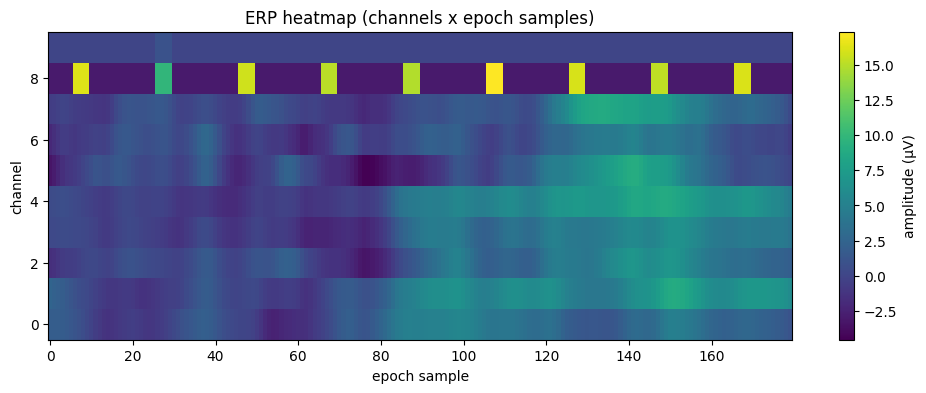

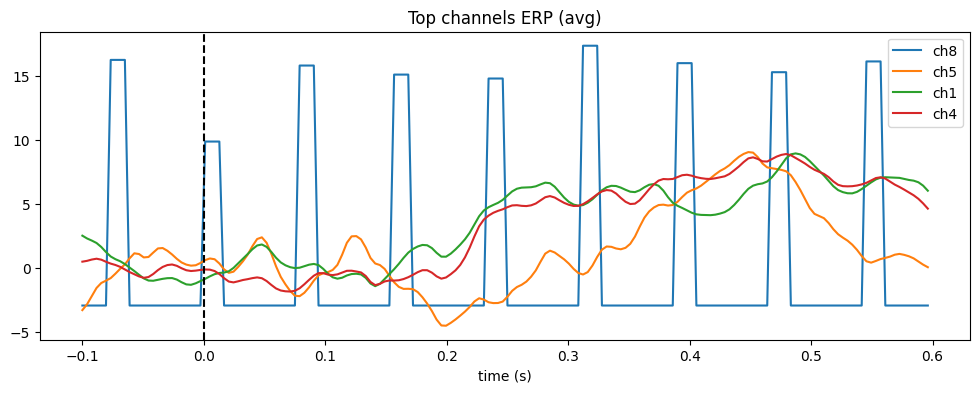

In [13]:
if epochs.shape[0] == 0:
    print("No epochs extracted. عدّل الاكتشاف أو المعاملات ثم أعد المحاولة.")
else:
    erp = np.mean(epochs, axis=0)  # shape (n_ch, epoch_len)
    times_epoch = np.linspace(-pre_s, post_s, epoch_len, endpoint=False)

    # Heatmap ERP
    plt.figure(figsize=(12,4))
    plt.imshow(erp, aspect='auto', origin='lower')
    plt.colorbar(label='amplitude (µV)')
    plt.title("ERP heatmap (channels x epoch samples)")
    plt.xlabel("epoch sample")
    plt.ylabel("channel")
    plt.show()

    # Plot top 4 channels by abs max in ERP
    absmax = np.max(np.abs(erp), axis=1)
    top_idxs = np.argsort(absmax)[-4:][::-1]
    plt.figure(figsize=(12,4))
    for idx in top_idxs:
        plt.plot(times_epoch, erp[idx], label=f"ch{idx}")
    plt.legend(); plt.title("Top channels ERP (avg)"); plt.xlabel("time (s)"); plt.axvline(0, color='k', linestyle='--'); plt.show()


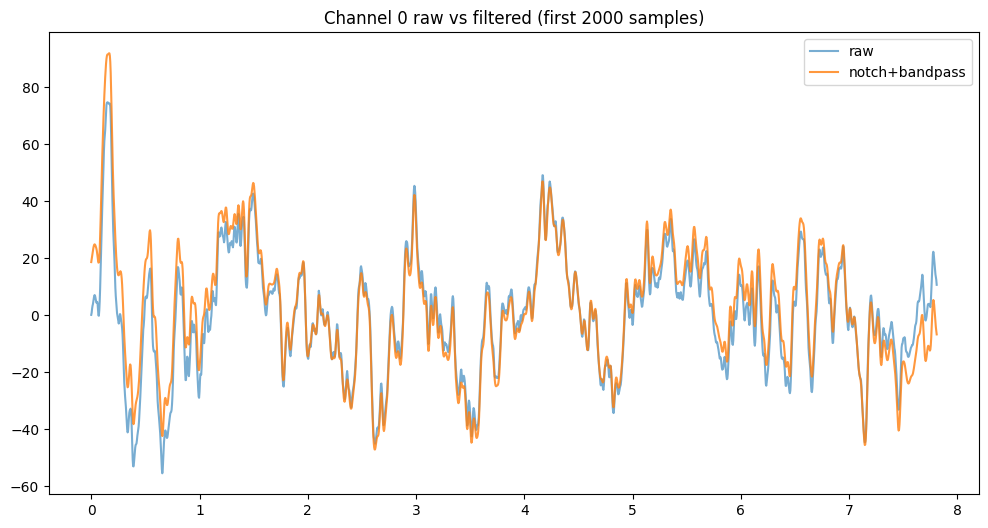

In [14]:

from scipy.signal import iirnotch, filtfilt, butter

def notch_filter(data, fs, f0=50.0, Q=30.0):
    b, a = iirnotch(f0/(fs/2), Q)
    return filtfilt(b, a, data)

def bandpass_filter(data, fs, low=0.1, high=30.0, order=4):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, data)

# مثال: فِلترة القناة الأولى لمشاهدة الفرق
ch = 0
raw = sig_train[ch, :2000]
notched = notch_filter(raw, sr, f0=50.0)
bp = bandpass_filter(notched, sr, low=0.1, high=30.0)

plt.figure(figsize=(12,6))
plt.plot(t_train[:2000], raw, label='raw', alpha=0.6)
plt.plot(t_train[:2000], bp, label='notch+bandpass', alpha=0.8)
plt.legend(); plt.title(f"Channel {ch} raw vs filtered (first 2000 samples)"); plt.show()

# لتطبيق على كامل المصفوفة (قد يستغرق وقتًا)
apply_full = False
if apply_full:
    sig_train_filt = np.zeros_like(sig_train)
    for i in range(sig_train.shape[0]):
        tmp = notch_filter(sig_train[i, :], sr, f0=50.0)
        sig_train_filt[i, :] = bandpass_filter(tmp, sr, 0.1, 30.0)
    print("Full filtering applied and stored in sig_train_filt")


In [15]:
# Cell 14
outfolder = '/content/s1_export'
os.makedirs(outfolder, exist_ok=True)

# احفظ epochs (إذا وُجدت)
if epochs.shape[0] > 0:
    np.savez_compressed(os.path.join(outfolder, 'epochs.npz'),
                        epochs=epochs, events=np.array(valid_events), sr=sr,
                        pre_s=pre_s, post_s=post_s)
    print("Saved epochs to epochs.npz")

# احفظ ERP
if epochs.shape[0] > 0:
    np.save(os.path.join(outfolder, 'erp.npy'), erp)
    print("Saved erp.npy")

# احفظ عيّنة CSV للقناة 0 (أول 2000 عينة)
pd.DataFrame({"time": t_train[:2000], "ch0": sig_train[0, :2000]}).to_csv(os.path.join(outfolder, 'train_ch0_sample.csv'), index=False)
print("Saved sample CSV and all to", outfolder)


Saved epochs to epochs.npz
Saved erp.npy
Saved sample CSV and all to /content/s1_export


## summary

### ملخص سريع للبيانات والمعالجة
- مصدر البيانات: Visual P300 speller (BNCI dataset variant).
- sampling rate: sampling rate ≈ 256.000 Hz
- signals: {11} channels (بعد إزالة time vector), time length train = {10}
- trigger channel (مقترح): {CH9}
- extracted epochs: {(75, 10, 180)}
- epoch window: pre {26} s  post {154} s
